In this notebook we have implemented a simple bandit algorithm described on page 32 with Upper-Confidence Bound Action Selection in Chapter 2.7

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("paper")
sns.set_theme("paper")
%matplotlib inline

In [2]:
num_testbed = 2000
num_armed_bandits = 10
num_experience_steps = 1000

testbed = np.random.normal(size=(num_testbed, num_armed_bandits))

In [3]:
def simple_bandit_algorithm(optimal_value, learned_value, value_occur, 
                            epsilon=0.0, num_learning_iters=1000, uba=True, uba_c=0.0):
    p_optimal_action = []
    average_reward = []
    best_action = np.argmax(optimal_value)
    num_possible_actions = len(learned_value)
    # loop by the specified number of iterations
    for learning_iters in range(1, num_learning_iters+1):
        if uba == True:
            action_uncertainties = uba_c * np.sqrt(np.log(learning_iters)/(value_occur))
            action = np.argmax(learned_value + action_uncertainties) # Equation (2.10)
        else:
            action_probs = (epsilon/num_possible_actions) * np.ones_like(learned_value)
            action_probs[np.argmax(learned_value)] += 1 - epsilon
            # select epsilon-greedy action based on pre-calculated probabilities
            action = np.random.choice(num_possible_actions, p=action_probs)
        p_optimal_action.append(int(action==best_action))
        random_rewards = np.random.normal(loc=optimal_value)
        value_occur[action] += 1
        learned_value[action] += (1/value_occur[action]) * (random_rewards[action] - learned_value[action])
        average_reward.append(random_rewards[action])
    return p_optimal_action, average_reward

def run_sba_with_UCB(optimal_values, learned_values, value_occurs, 
                     epsilon=0.0, num_learning_iters=1000, uba=True, uba_c=0.0):
    percent_optimal_action = []
    average_reward_history = []
    for optimal_value, learned_value, value_occur in zip(optimal_values, learned_values, value_occurs):
        p_optimal_action, average_reward = simple_bandit_algorithm(optimal_value, learned_value, value_occur, 
                                                              epsilon, num_learning_iters, uba, uba_c)
        percent_optimal_action.append(p_optimal_action)
        average_reward_history.append(average_reward)
    return np.array(percent_optimal_action), np.array(average_reward_history)

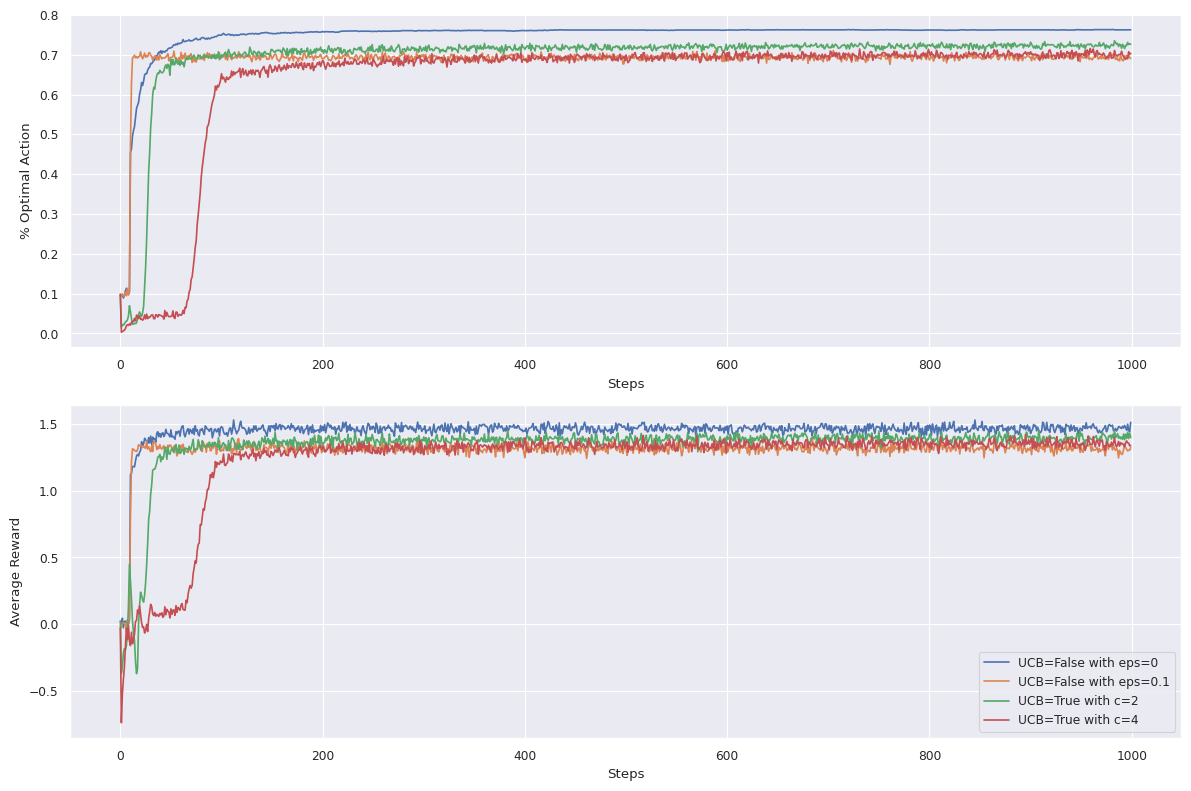

In [4]:
optimistic_init_value = 5
value_select_counts = 1e-1 + np.zeros_like(testbed)
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

for eps in [0, 1e-1]:
    learned_value_estimates = optimistic_init_value * np.ones_like(testbed)
    percent_optimal_action, average_reward_history = run_sba_with_UCB(optimal_values=testbed, learned_values=learned_value_estimates, 
                                                                      value_occurs=value_select_counts, epsilon=eps, 
                                                                      num_learning_iters=num_experience_steps, uba=False)
    # visualizing results over learning steps
    axis[0].plot(np.arange(0, num_experience_steps), np.mean(percent_optimal_action, axis=0, keepdims=True).reshape(-1), 
                 label=f"UCB={False} with eps={np.round(eps, decimals=3)}")
    axis[1].plot(np.arange(0, num_experience_steps), np.mean(average_reward_history, axis=0, keepdims=True).reshape(-1), 
                 label=f"UCB={False} with eps={np.round(eps, decimals=3)}")
    
for uba_c in [2, 4]:
    learned_value_estimates = optimistic_init_value * np.ones_like(testbed)
    percent_optimal_action, average_reward_history = run_sba_with_UCB(optimal_values=testbed, learned_values=learned_value_estimates, 
                                                                      value_occurs=value_select_counts, epsilon=eps, 
                                                                      num_learning_iters=num_experience_steps, uba=True, uba_c=uba_c)
    # visualizing results over learning steps
    axis[0].plot(np.arange(0, num_experience_steps), np.mean(percent_optimal_action, axis=0, keepdims=True).reshape(-1), 
                 label=f"UCB={True} with c={uba_c}")
    axis[1].plot(np.arange(0, num_experience_steps), np.mean(average_reward_history, axis=0, keepdims=True).reshape(-1), 
                 label=f"UCB={True} with c={uba_c}")

axis[0].set_xlabel("Steps")
axis[0].set_ylabel("% Optimal Action")
axis[1].set_xlabel("Steps")
axis[1].set_ylabel("Average Reward")    
fig.tight_layout()
plt.legend()
plt.show()

Although UCB with c = 2 performs better than \epsilon greedy approach with \epsilon=0.1, greedy strategy seems to work much better than all tested methods in a long run. Furthermore, increasing 'c' parameter seems to have an adverse effect on the performance